### Import Libraries:

In [1]:
import gym
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
env = gym.make('Blackjack-v0')
env.reset()
a,b,c,d,e = env.step(0)
print(e)

[7, 9, 1]


### Create Agent

In [3]:
class Agent():
    def __init__(self, env, epsilon=1.0, gamma=0.99, num_episodes_to_train=30000, timestep=0):
        self.env = env

        # Looks like n is number of valid actions from the souce code
        self.valid_actions = list(range(self.env.action_space.n))

        # Set parameters of the learning agent
        self.Q = dict()          # Q-table which will be a dictionary of tuples
        self.epsilon = epsilon   # Random exploration factor
        #self.alpha = alpha       # Learning factor
        self.gamma = gamma       # Discount factor- closer to 1 learns well into distant future
        self.visits = dict()
        
        self.num_episodes_to_train = num_episodes_to_train # Change epsilon each episode based on this


        #self.num_episodes_to_train_left = num_episodes_to_train
        self.timestep = timestep
        
    def updateEpsilon(self):
        epsilonStart = 1
        epsilonEnd = 0
        scalingFactor = 100
        self.epsilon = epsilonStart + (epsilonEnd-epsilonStart)*np.exp(
                       (self.timestep-self.num_episodes_to_train)/scalingFactor)

    def update_parameters(self):

        #self.timestep += 1
        if self.timestep <= self.num_episodes_to_train:
            self.updateEpsilon()
        else:
            self.epsilon = 0

    def create_Q_if_new_observation(self, observation):

        if observation not in self.Q:
            self.Q[observation] = dict((action, 0.0) for action in self.valid_actions)
            self.visits[observation] = dict((action, 1) for action in self.valid_actions)

    def get_maxQ(self, observation):

        self.create_Q_if_new_observation(observation)
        return max(self.Q[observation].values())

    def choose_action(self, observation):

        self.create_Q_if_new_observation(observation)

        # uniformly distributed random number > epsilon happens with probability 1-epsilon
        if random.random() > self.epsilon:
            maxQ = self.get_maxQ(observation)

            # multiple actions could have maxQ- pick one at random in that case
            # this is also the case when the Q value for this observation were just set to 0.0
            action = random.choice([k for k in self.Q[observation].keys()
                                    if self.Q[observation][k] == maxQ])
        else:
            action = random.choice(self.valid_actions)
        
        self.visits[observation][action] += 1
        self.update_parameters()

        return action


    def learn(self, observation, action, reward, next_observation):
   
        # Q = Q*(1-alpha) + alpha(reward + discount * utility of next observation)

        alpha = 1/(1+self.visits[observation][action])
        self.Q[observation][action] = (1-alpha)*self.Q[observation][action] + (
                                      (alpha)*(reward+(self.gamma*self.get_maxQ(next_observation))))

### Training over Number of Episodes:

For Gamma:  0.1
Average payout after 1000 rounds after training for 5000 episodes is -92.08
Average payout after 1000 rounds after training for 10000 episodes is -124.8
Average payout after 1000 rounds after training for 15000 episodes is -161.78
Average payout after 1000 rounds after training for 20000 episodes is -187.62
Average payout after 1000 rounds after training for 25000 episodes is -226.7
Average payout after 1000 rounds after training for 30000 episodes is -251.98
Average payout after 1000 rounds after training for 35000 episodes is -299.34
Average payout after 1000 rounds after training for 40000 episodes is -327.72
Average payout after 1000 rounds after training for 45000 episodes is -368.42
Average payout after 1000 rounds after training for 50000 episodes is -388.18


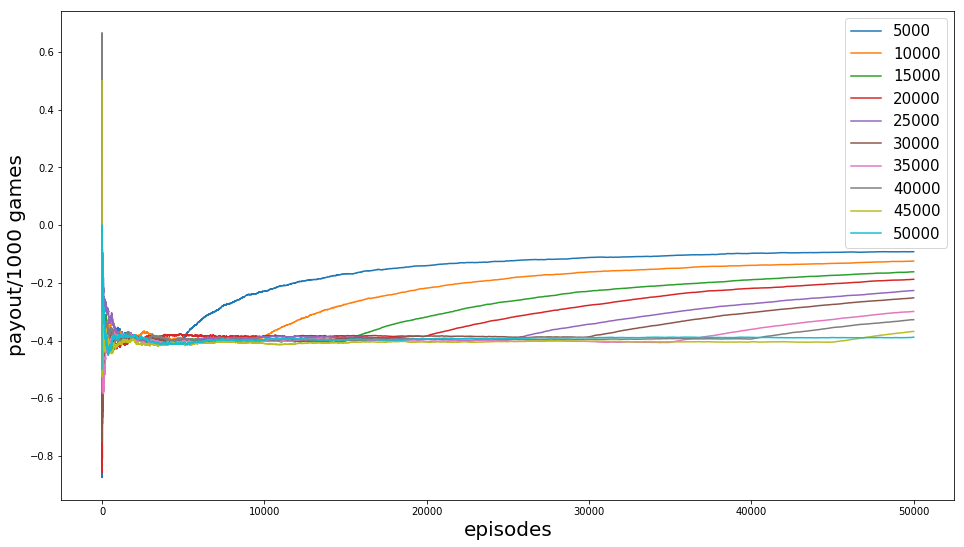

[-4604.0, -6240.0, -8089.0, -9381.0, -11335.0, -12599.0, -14967.0, -16386.0, -18421.0, -19409.0]


In [5]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
env = gym.make('Blackjack-v0')
plt.rcParams["figure.figsize"] = [16,9]

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 50 # num_rounds simulated over num_samples


num_episodes_values = range(5000, 55000, 5000)

# plt.figure(num=None, figsize=(16, 12))
plt.clf()

gamma_value = np.arange(0.1,0.2,0.1)

# Run simulations over different values of 'num_episodes_to_train' to find the one with best payout
gamma_list=[]
for gamma1 in gamma_value:
    
    print('For Gamma: ',gamma1)
    
    for num_episodes_value in num_episodes_values:
        total_payout = 0 # to store total payout over 'num_rounds'
        average_payouts = [] # to store total payout over 'num_rounds' after 'num_sample' simulations
        agent = Agent(env=env, epsilon=1.0, gamma=gamma1, num_episodes_to_train=num_episodes_value)
        
        observation = env.reset()
        for sample in range(num_samples):
            round = 1
            # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
            while round <= num_rounds:
                action = agent.choose_action(observation)
                next_observation, payout, is_done, _, _ = env.step(action)
                agent.learn(observation, action, payout, next_observation)
                total_payout += payout
                observation = next_observation
                if is_done:
                    agent.timestep += 1
                    observation = env.reset() # Environment deals new cards to player and dealer
                    round += 1
                    average_payouts.append(total_payout/(sample*num_rounds + round))  
       
        plt.plot(average_payouts)
        gamma_list.append(total_payout)
        print ("Average payout after {} rounds after training for {} episodes is {}".format(num_rounds, num_episodes_value, total_payout/(num_samples)))
        
        
    # Plot payout per 1000 episodes for each value of 'num_episodes_to_train' in the same graph
    plt.xlabel('episodes',fontsize=20)
    plt.ylabel('payout/1000 games',fontsize=20)
    plt.legend(["{}".format(i) for i in num_episodes_values], loc='upper right', fontsize=15)
#     plt.ylim(-0.5,0) # To zoom into this region
    plt.show()
    env.close()
    
    print(gamma_list)

### Visualize Parameter Tuning

In [7]:
import pandas as pd
hypertable = np.asarray(gamma_list)
hypertable = np.reshape(hypertable,(10,10))

df = pd.DataFrame(hypertable,columns=['5000', '10000','15000','20000','25000','30000','35000','40000','45000','50000'], 
                   index=['Gamma: 0.1', 'Gamma: 0.2','Gamma: 0.3','Gamma: 0.4','Gamma: 0.5','Gamma: 0.6','Gamma: 0.7',
                         'Gamma: 0.8','Gamma: 0.9','Gamma: 1.0'])
display(df)

plt.imshow(hypertable, cmap='YlGnBu')
plt.xlabel('No of training episodes',fontsize=20)
plt.ylabel('Gamma',fontsize=20)

ValueError: cannot reshape array of size 10 into shape (10,10)

### Plot the change in epsilon over 1000 rounds, 1 sample

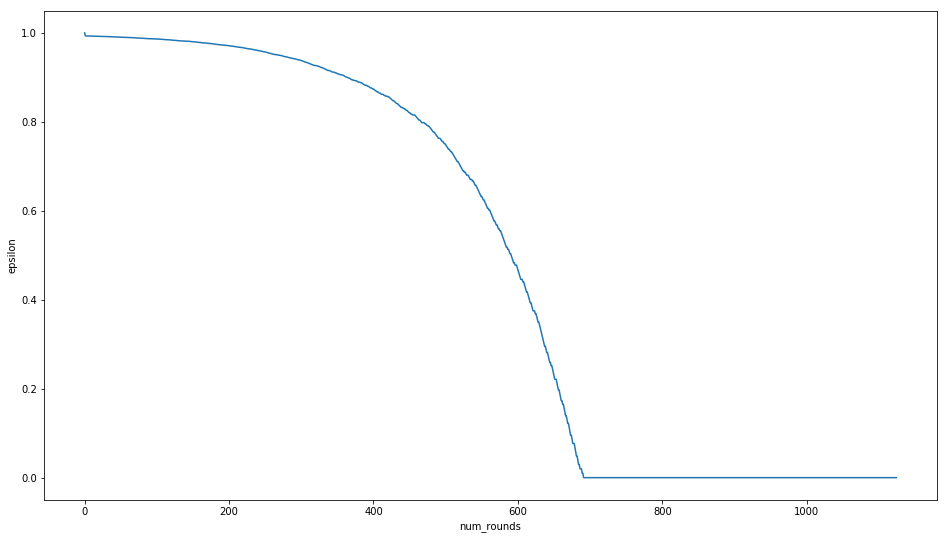

Average payout after 800 rounds is -226.0


In [8]:
total_payout = 0 # to store total payout over 'num_rounds'
average_payouts = []
agent = Agent(env=env, epsilon=1.0, gamma=0.9, num_episodes_to_train=500, timestep=0)

num_rounds = 800 # Payout calculated over num_rounds
num_samples = 1 # num_rounds simulated over num_samples


observation = env.reset()
for sample in range(num_samples):
    round = 1
    epsilon_values = []
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        epsilon_values.append(agent.epsilon)
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            agent.timestep += 1
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
            average_payouts.append(total_payout/(sample*num_rounds + round))

# Plot epsilon over rounds to show rate of its decrease
plt.figure(2)
plt.xlabel("num_rounds")
plt.ylabel("epsilon")
plt.plot(epsilon_values)
plt.show()
print ("Average payout after {} rounds is {}".format(num_rounds, total_payout/(num_samples)))

### Training the Agent

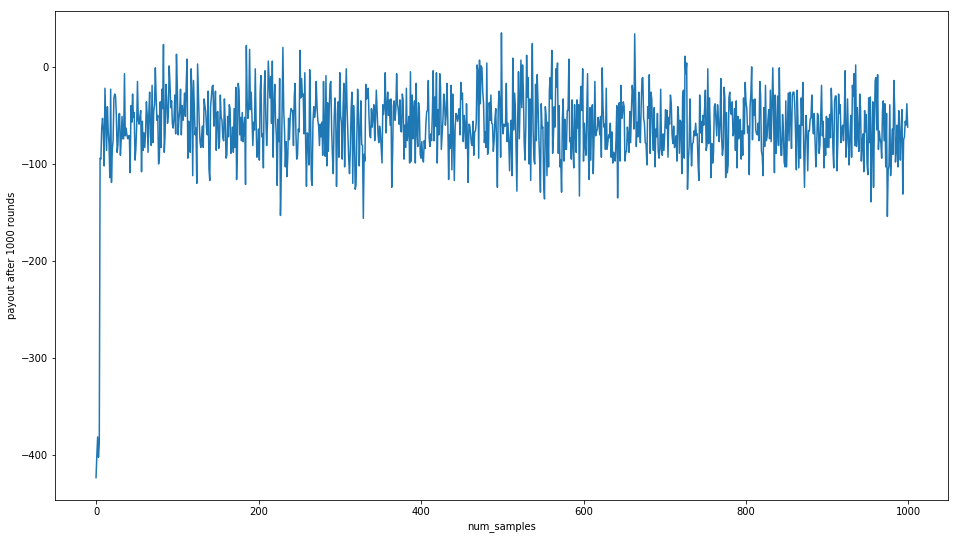

Average payout after 1000 rounds is -61.013


In [9]:
agent = Agent(env=env, epsilon=1.0, gamma=0.1, num_episodes_to_train=5000, timestep=0)

num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 1000 # num_rounds simulated over num_samples

average_payouts = []

observation = env.reset()
for sample in range(num_samples):
    round = 1
    total_payout = 0 # to store total payout over 'num_rounds'
    # Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
    while round <= num_rounds:
        action = agent.choose_action(observation)
        next_observation, payout, is_done, _, _ = env.step(action)
        agent.learn(observation, action, payout, next_observation)
        total_payout += payout
        observation = next_observation
        if is_done:
            agent.timestep += 1
            observation = env.reset() # Environment deals new cards to player and dealer
            round += 1
    average_payouts.append(total_payout)

# Plot payout per 1000 episodes for each value of 'sample'
plt.plot(average_payouts)           
plt.xlabel('num_samples')
plt.ylabel('payout after 1000 rounds')
plt.show()      
    
print ("Average payout after {} rounds is {}".format(num_rounds, sum(average_payouts)/(num_samples)))

In [56]:
#Trained GameBot: 

#Visualizing the game:

import gym
env=gym.make('Blackjack-v0')

observation1 = env.reset()
print('1',observation1)

action = agent.choose_action(observation1)
print('2',action)

next_observation, payout, is_done, _,dealer_cards = env.step(action)
print('3',next_observation, payout, is_done)

observation2 = next_observation

action = agent.choose_action(observation2)
print('2',action)

next_observation, payout, is_done, _,dealer = env.step(action)
print('3',next_observation, payout, is_done,'\n','Cards drawn by dealer:','\n',dealer_cards)

observation3 = next_observation

action = agent.choose_action(observation3)
print('2',action)

next_observation, payout, is_done, _,dealer = env.step(action)
print('3',next_observation, payout, is_done,'\n','Cards drawn by dealer:','\n',dealer_cards)

1 (21, 7, True)
2 0
3 (21, 7, True) 1.0 True
2 0
3 (21, 7, True) 1.0 True 
 Cards drawn by dealer: 
 [7, 10]
2 0
3 (21, 7, True) 1.0 True 
 Cards drawn by dealer: 
 [7, 10]


In [101]:
def play_game(observation):
    action = agent.choose_action(observation)
    
    if action==1:
        print('Agent decides to HIT')
    elif action==0:
        print('Agent decides to STAND')
    print('\n')
        
#     next_observation, payout, is_done, _,dealer_cards = env.step(action)
#     print('New Card Value (Sum) of Player: ',next_observation[0],'\n',
#           'Card Value of Dealer:',next_observation[1],'\n',
#           'Is the hand soft (contains an ace)',next_observation[2],'\n',
#           'Reward is: ',payout,'\n',
#           'Is the game done?',is_done)

    next_observation, payout, is_done, _,dealer_cards = env.step(action)
    print('Reward: ',payout,'\n',
        'Is the game done?',is_done)


    print('\n')
    if is_done==True:
        print('\n')
        print('Dealer Cards drawn: ', dealer_cards[1:],
             'Sum of Dealers cards: ', np.sum(dealer_cards))
    
    return next_observation, payout, is_done
    

In [103]:
import gym
env=gym.make('Blackjack-v0')

#Get first observation:
observation1 = env.reset()

#Values of the first hand:
is_done=False

if observation1[0]==21:
    print('Blackjack!!')

while is_done==False:
    if observation1[0]==21:
        print('Blackjack! You should go to Vegas')

    else:
        print('Card Value (Sum) of Player: ',observation1[0],'\n',
             'Card Value of Dealer: ',observation1[1],'\n',
             'Is the hand soft (contains an ace)',observation1[2],'\n')

        print('What would you do? HIT=1, STAND=0')
        print('\n')
        a = int(input())




    #Player decision:
    if a ==1:
        print('You chose to HIT')
    elif a==0:
        print('You chose to STAND')
    else:
        print('Enter either 0 or 1')

    print('\n')


    #Agent Decision:
    observation2,reward, is_done = play_game(observation1)
    observation1=observation2
    
    if is_done==True:
        
        if reward==1:
            print('Agent won the game!! Do your actions match the agents?')
        elif reward==-1:
            print('Arghh! Agent lost the game :( Never give up on gambling though')
        else:
            print('A draw! Lets paly another round')
        break



Card Value (Sum) of Player:  16 
 Card Value of Dealer:  4 
 Is the hand soft (contains an ace) False 

What would you do? HIT=1, STAND=0


0
You chose to STAND


Agent decides to STAND


Reward:  -1.0 Is the game done? True




Dealer Cards drawn:  [6, 2, 8] Sum of Dealers cards:  20
Arghh! Agent lost the game :( Never give up on gambling though


In [23]:
learnedStrategy = open('AgentStrategy.txt','w')

In [23]:
num_rounds = 1000 # Payout calculated over num_rounds
num_samples = 100 # num_rounds simulated over num_samples

payouts = []

observation = env.reset()
round = 1
total_payout = 0 # to store total payout over 'num_rounds'
# Take action based on Q-table of the agent and learn based on that until 'num_episodes_to_train' = 0
while round <= num_rounds * num_samples:
    action = agent.choose_action(observation)
    next_observation, payout, is_done, _,_ = env.step(action)
    agent.learn(observation, action, payout, next_observation)
    payouts.append(payout)
    observation = next_observation
    if is_done:
        observation = env.reset() # Environment deals new cards to player and dealer
        round += 1

num_observations = 0        
list_players_hand = range(1, 22)
list_dealers_upcard = range(1, 11)

def readable_action(observation, agent):
    """ 
    Pass observation to agent and get human readable action
    H is hit, S is stick and '-' means the state is unseen and a random action is taken
    """
    if observation not in agent.Q:
        action = "-"
    else:
        action = "H" if agent.choose_action(observation) else "S"    
    return action

# Print headers to give more information about output
learnedStrategy.write("{:^10} | {:^50} | {:^50}".format(
                      "Player's","Dealer's upcard when ace is not usable",
                      "Dealer's upcard when ace is usable"))
learnedStrategy.write("{0:^10} | {1} | {1}".format("Hand", [str(upcard) if not upcard==10 else 'A' 
                                                        for upcard in list_dealers_upcard]))
print (''.join(['-' for _ in range(116)]))
for players_hand in list_players_hand:
    actions_usable = []
    actions_not_usable = []
    for dealers_upcard in list_dealers_upcard:
        observation = (players_hand, dealers_upcard, False)
        actions_not_usable.append(readable_action(observation, agent))
        observation = (players_hand, dealers_upcard, True)
        actions_usable.append(readable_action(observation, agent))
    
    learnedStrategy.write("{:>10} | {} | {}".format(
                          players_hand, actions_not_usable, actions_usable))

    
learnedStrategy.write("Average payout after {} rounds is {}".format(
                       num_rounds, sum(payouts)/num_samples))

learnedStrategy.close()

--------------------------------------------------------------------------------------------------------------------
